In [1]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import PathologicalPartitioner

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

/home/sbaldasty/.venvs/heracleum/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-28 18:38:55,155	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Training on cpu
Flower 1.11.1 / PyTorch 2.2.1+cu121


/home/sbaldasty/.venvs/heracleum/lib/python3.10/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
NUM_CLIENTS = 10
BATCH_SIZE = 64
LOCAL_EPOCHS = 5
GLOBAL_ROUNDS = 15

In [3]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [5]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

In [6]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=LOCAL_EPOCHS)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"loss": float(loss), "accuracy": float(accuracy)}

In [7]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}
    # Refer to our Flower framework documentation for more details about Flower simulations
    # and how to set up the `backend_config`

In [8]:
all_losses = []

In [9]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    losses = [num_examples * m["loss"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    all_losses.append(sum(losses) / sum(examples))
    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [10]:
def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour.

    You can use settings in `context.run_config` to parameterize the
    construction of all elements (e.g the strategy or the number of rounds)
    wrapped in the returned ServerAppComponents object.
    """

    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.5,
        min_fit_clients=10,
        min_evaluate_clients=5,
        min_available_clients=10,
        evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    )

    # Configure the server for 5 rounds of training
    config = ServerConfig(num_rounds=GLOBAL_ROUNDS)

    return ServerAppComponents(strategy=strategy, config=config)


# Create a new server instance with the updated FedAvg strategy
server = ServerApp(server_fn=server_fn)

# Run simulation
for labels_per_partition in range(1, 11):
    # From https://www.kaggle.com/code/snehilsanyal/2-partitioners-in-federated-dataset-with-flower
    partitioner = PathologicalPartitioner(
        num_partitions=10, partition_by="label", num_classes_per_partition=labels_per_partition
    )

    def load_datasets(partition_id: int):
        fds = FederatedDataset(dataset="cifar10", partitioners={"train": partitioner})
        partition = fds.load_partition(partition_id)
        # Divide data on each node: 80% train, 20% test
        partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
        pytorch_transforms = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
        )

        def apply_transforms(batch):
            # Instead of passing transforms to CIFAR10(..., transform=transform)
            # we will use this function to dataset.with_transform(apply_transforms)
            # The transforms object is exactly the same
            batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
            return batch

        # Create train/val for each partition and wrap it into DataLoader
        partition_train_test = partition_train_test.with_transform(apply_transforms)
        trainloader = DataLoader(
            partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True
        )
        valloader = DataLoader(partition_train_test["test"], batch_size=BATCH_SIZE)
        testset = fds.load_split("test").with_transform(apply_transforms)
        testloader = DataLoader(testset, batch_size=BATCH_SIZE)
        return trainloader, valloader, testloader

    def client_fn(context: Context) -> Client:
        """Create a Flower client representing a single organization."""

        # Load model
        net = Net().to(DEVICE)

        # Load data (CIFAR-10)
        # Note: each client gets a different trainloader/valloader, so each client
        # will train and evaluate on their own unique data partition
        # Read the node_config to fetch data partition associated to this node
        partition_id = context.node_config["partition-id"]
        trainloader, valloader, _ = load_datasets(partition_id=partition_id)

        # Create a single Flower client representing a single organization
        # FlowerClient is a subclass of NumPyClient, so we need to call .to_client()
        # to convert it to a subclass of `flwr.client.Client`
        return FlowerClient(net, trainloader, valloader).to_client()

    # Create the ClientApp
    client = ClientApp(client_fn=client_fn)

    run_simulation(
        server_app=server,
        client_app=client,
        num_supernodes=NUM_CLIENTS,
        backend_config=backend_config
    )

INFO :      Starting Flower ServerApp, config: num_rounds=15, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(ClientAppActor pid=1494070) /home/sbaldasty/.venvs/heracleum/lib/python3.10/site-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [1, 3, 5, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1494070)   warnings.warn(
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=1494070) /home/sb

In [14]:
split_losses = [all_losses[i:i + GLOBAL_ROUNDS] for i in range(0, len(all_losses), GLOBAL_ROUNDS)]
print(split_losses)

[[0.05232556963802363, 0.028020445002291255, 0.05165533391639911, 0.03504165325391378, 0.03227160515458718, 0.04422684890520632, 0.053484671905527734, 0.057608654664390135, 0.04028501329350086, 0.04456099080138908, 0.04909001682147823, 0.04553449883668319, 0.03745662767634897, 0.028396046059080006, 0.037609734003585325], [0.03745250325408708, 0.032219233377777115, 0.02905978295195126, 0.02824485526357735, 0.026385987130321, 0.02637073719596694, 0.025145698691615145, 0.024250684927439675, 0.024984302370774522, 0.02595390937471829, 0.02173648093578348, 0.023517800890671826, 0.022181395836595116, 0.022478556456092872, 0.023180897960368017], [0.03637382732361207, 0.033760376594316036, 0.03333853422775355, 0.03270506359939774, 0.03253779264105247, 0.030242114715156476, 0.0254985743477565, 0.03457705022563325, 0.02948603886816727, 0.029491765510555233, 0.032484501706110745, 0.02245939707161928, 0.030298022468559786, 0.021362284716439885, 0.034690272411108], [0.03478931355747539, 0.0301269711

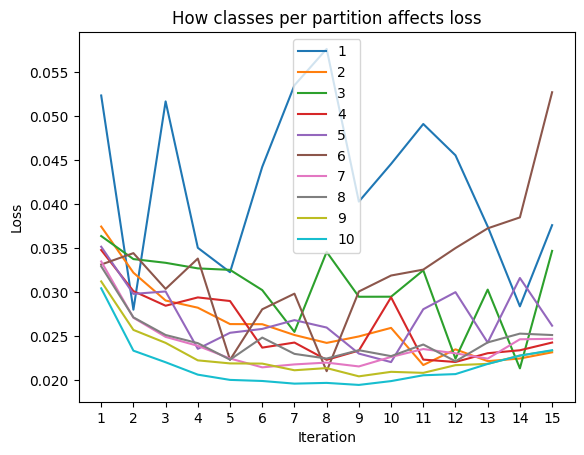

In [22]:
iterations = list(range(1, GLOBAL_ROUNDS + 1))
plt.title('How classes per partition affects loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.xticks(iterations)

for j in range(10):
    line = [split_losses[j][k] for k in range(GLOBAL_ROUNDS)]
    plt.plot(iterations, line, label=f'{j + 1}')

plt.legend()
plt.show()